#### Template

*This Notebook is part of a Github Repository Template defining a Project File Structure. (See README.md)*

```.
├── config.yaml
├── data
│   └── README_data.md
├── environment.yaml
├── README.md
├── scripts
│   ├── clean.sh
│   ├── downsample.sh
│   ├── generate_reference.sh
│   ├── nb2py.sh
│   ├── README_scripts.md
│   └── run_ubs_seq.sh
├── src
│   └── README_IGV_WEB.md
└── workspace
    ├── README_workspace.md
    ├── ubs_basic.ipynb
    └── ubs_basic.py
```

In [29]:
from pathlib import Path
home_path      = Path.cwd()/'..'
data_path      = home_path/'data'
workspace_path = home_path/'workspace'

# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**3/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Convert Notebook to Script to Execute from the Command Line

```
# cd workplace/
# juptyer nbconvert ubs_basic.ipynb --to script
# ipython ubs_basic.py
```

#### Environment

In [3]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile

In [4]:
def fname(path, base, sufix):
    'Return a path and suffix complete filename'
    return Path(path)/f"{base}.{sufix}"

def mkpath(path):
    'Return dir path name; creates (not over-writting) a new dir within the pwd. Also prints date/time executed'
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)
    date = ! date "+%H:%M:%S_%m-%d-%Y"
    print(f">>> {{{path}}} {date[0]}")
    return path

In [5]:
# Set Java Flag
os.environ['_JAVA_OPTIONS'] = '-Xmx8g'

In [6]:
# Number of cores                                                                                                                                                                                               
nc = get_ipython().getoutput('nproc')                                                                                                                                                                           
nc = int(nc[0])                                                                                                                                                                                                 
nc  

32

In [7]:
# Programs added to shell PATH
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n

#### Functions

In [8]:
def nlines(file):
    'Returns fast linecout (fast)'
    result = subprocess.run(['wc', '-l', file], stdout=subprocess.PIPE)
    n = int(result.stdout.split()[0])
    return n

In [9]:
def nseqs(bam_fastq):
    'Returns number of sequences in bam, sam, fasta or fastq file'
    n = !samtools view -c {bam_fastq}
    return int(n[0])

In [10]:
def samples_string(samples,path,suffix='bam'):
    'Returns a space delimited string of sample files'
    return " ".join([str(fname(path,sample,suffix)) for sample in samples])    

In [11]:
def make_table(ds1, ds2, ds1_name, ds2_name, y_label=None, xs_labels=None, table_label=None):
    'Makes a bar graph comparing two datasets and their corresponding names'
    assert(len(ds1)==len(ds2))
    n = np.arange(len(ds1))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(n - width/2, ds1, width, label=ds1_name)
    rects2 = ax.bar(n + width/2, ds2, width,label=ds2_name)
    ax.set_ylabel(y_label)
    ax.set_title(table_label)
    ax.set_xticks(n)
    ax.set_xticklabels(range(1,len(ds1)+1)) if xs_labels == None else ax.set_xticklabels(xs_labels)
    ax.legend()
    plt.show()

In [12]:
def make_histogram(ds, ds_name, table_label=None, y_label="Frequency", density=True):
    'Makes a histogram for a dataset and its name'
    fig, ax = plt.subplots()
    ax.hist(ds, density=density)
    ax.set_ylabel(y_label)
    ax.set_xlabel(ds_name)
    if table_label is not None:
        ax.set_title(table_label)
    plt.show()

#### Define `references/`

Use `config.yaml` to configure `references/`, but not samples in `data/`

In [13]:
config = load_configfile("../config.yaml")

In [14]:
genome_fa  = home_path/config['reference']['genome']['fa'].removeprefix('~/')
genome_idx = home_path/config['reference']['genome']['hisat3n'].removeprefix('~/')
print(genome_fa)
print(genome_idx)

/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../reference/genome/Homo_sapiens.GRCh38.genome.fa
/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../reference/index/hisat3n/Homo_sapiens.GRCh38.genome/Homo_sapiens.GRCh38.genome


## Step: select_samples

#### Define sample names and link to sample files

In [30]:
out_path = mkpath('samples')

>>> {samples} 20:55:59_03-02-2024


Define short sample names for samples in groups {treated, control}

In [134]:
treated = ["t1","t2"] # Edit
control = ["c1"] # Edit
samples = treated + control
print(treated, control, samples)

['t1', 't2'] ['c1'] ['t1', 't2', 'c1']


Sample files

In [32]:
samples_fn = [data_path/'test1_R1.fq.gz', data_path/'test2_R1.fq.gz', data_path/'test3_R1.fq.gz']

In [33]:
s2fn = {name: fname for (name,fname) in zip(samples,samples_fn)};
s2fn

{'t1': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test1_R1.fq.gz'),
 't2': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test2_R1.fq.gz'),
 'c1': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test3_R1.fq.gz')}

Symbolically link short names with sample files

In [34]:
for (s,fn) in s2fn.items():
    ! ln -s {data_path/fn} {fname(out_path,s,"fq.gz")}

Check that the files look correct

In [35]:
!ls -lLh {out_path}

total 131M
-rw-rw-r-- 1 cdaniels cdaniels 47M Mar  2 20:55 c1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 37M Mar  2 20:54 t1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 49M Mar  2 20:55 t2.fq.gz


How many sequence reads do we have per Sample

In [ ]:
# Total Reads per Samples

#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#for f in files:
#    ns = nseqs(f)
#    print(f"{f}: {ns:,}")

## Step: fastqc_pre

#### Pre Trimming Quality Control

In [36]:
in_path = mkpath("samples")
out_path = mkpath("fastqc_pre")

>>> {samples} 20:57:07_03-02-2024
>>> {fastqc_pre} 20:57:07_03-02-2024


#### fastqc

In [ ]:
#! fastqc --help

##### paramaters:
- -o output dir

In [37]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for c1.fq.gz


In [40]:
! ls -l {out_path}

total 3052
-rw-rw-r-- 1 cdaniels cdaniels 653096 Mar  2 20:57 c1_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 400233 Mar  2 20:57 c1_fastqc.zip
-rw-rw-r-- 1 cdaniels cdaniels 647152 Mar  2 20:57 t1_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 383184 Mar  2 20:57 t1_fastqc.zip
-rw-rw-r-- 1 cdaniels cdaniels 650105 Mar  2 20:57 t2_fastqc.html
-rw-rw-r-- 1 cdaniels cdaniels 382708 Mar  2 20:57 t2_fastqc.zip


## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [95]:
in_path = mkpath("samples")
out_path = mkpath("trim")

>>> {samples} 22:58:45_03-02-2024
>>> {trim} 22:58:45_03-02-2024


In [78]:
adapter =  "AGATCGGAAGAGCACACGTCT"
barcode3 = "ATCACG"

In [79]:
!ls {in_path}

c1.fq.gz  t1.fq.gz  t2.fq.gz


#### cutadapt

In [ ]:
#! cutadapt --help

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

In [96]:
for sample in samples:
    !cutadapt -j 0 -n 2 \
        -a '{barcode3}{adapter};e=0.15;o=6;anywhere;' \
        --untrimmed-output={fname(out_path,sample,'untrimmed')} \
        -o {fname(out_path,sample,'tmp')}\
        {fname(in_path,sample,'fq.gz')} > {fname (out_path,sample,'report1')} 
    
    !cutadapt -j 0 -u 5 -u -5 --max-n=0 -q 15 -m 20 --length 80 --nextseq-trim=15 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,'tooshort')} \
            -o {fname(out_path,sample,"fq.gz")} \
            {fname(out_path,sample,'tmp')} > {fname(out_path,sample,'report2')}
    
    !rm {fname(out_path,sample,'tmp')}

Done           00:00:00       935,632 reads @   0.9 µs/read;  65.90 M reads/minute
Done           00:00:01       910,046 reads @   1.1 µs/read;  52.56 M reads/minute
Done           00:00:01     1,365,245 reads @   0.9 µs/read;  69.31 M reads/minute
Done           00:00:01     1,335,535 reads @   1.0 µs/read;  57.97 M reads/minute
Done           00:00:01     1,183,321 reads @   0.9 µs/read;  66.66 M reads/minute
Done           00:00:01     1,158,613 reads @   1.1 µs/read;  54.14 M reads/minute


#### Analysis

Take a look at a FASTQ file

In [75]:
in_fn  = fname(in_path,treated[0],'fq.gz')
out_fn = fname(out_path,treated[0],'fq.gz')
out_fn

PosixPath('trim/t1.fq.gz')

In [97]:
! zcat {in_fn}|head -16

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC
+
FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFF,FFF:F
@SRR23538290.144 144 length=121
TTTTTTTGGATATTAGGAAAAAATTTTGTAGAGAGAGTAAAAAATTTACTAGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTGCT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:,FF,F:FFFFFF
@SRR23538290.276 276 length=121
CCAGGAATTATAGTAATGTTTAGTTTATTGAGTTAAATGTTTGTCGGATGTGTTTGTGAGGGGATGAGGATGATAAGATTTTGTTTAGTATCACGAGATCGGAAGAGCACACGTCTGAACT
+
FF:,FFF:,FFF,FFF:FFFFFFFFFFFF,F:F:F:F,F,:,FFF,,F,F,,:,:,,FFFFF:FF:F,,F,,FF,F:,,,F,F,F:F::F::FFFFFFF:FFFF:FF,FFFFFFFFF,FFF
@SRR23538290.379 379 length=121
CCTCAAGAGTTTTAATGTTTTTAATGTAGGTGATGATTGGGAAAACACATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTTCTTGAAA
+
FFF,:,FFF:FF

In [81]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [98]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [99]:
reads = !zcat {out_fn}| head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

In [84]:
!ls {out_path}

c1.fq.gz    c1.tooshort   t1.report1   t1.untrimmed  t2.report2
c1.report1  c1.untrimmed  t1.report2   t2.fq.gz      t2.tooshort
c1.report2  t1.fq.gz	  t1.tooshort  t2.report1    t2.untrimmed


What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

It appears to has included in the fastq header, an id comprised of the first and last 5 nt cut by `-u 5` and `-u -5`

In [85]:
! zcat {in_fn}|head -2  

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC

gzip: stdout: Broken pipe


In [87]:
!zcat {out_fn}| head -2

@SRR23538290.50_GGAAAATGGT 50 length=121
TTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTT

gzip: stdout: Broken pipe


Too slow for large files. Commented out.

In [ ]:
#files = [fname(in_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#ins = res
#ins

In [ ]:
#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#outs = res
#outs

In [ ]:
#make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

In [ ]:
#reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
#ds = [len(read) for read in reads]
#make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [88]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 22:45:56_03-02-2024
>>> {fastqc_post} 22:45:56_03-02-2024


In [89]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for c1.fq.gz


#### Consolidate fastqc Reports

In [90]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=60257;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.21 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 6/6  0/6  
|            fastqc | Found 3 reports
|           multiqc | Report      : fastqc_post/multiqc.html
|           multiqc | Data        : fastqc_post/multiqc_data
|           multiqc | MultiQC complete


In [ ]:
! ls {out_path}

## Step: Hisat3n_align

#### Align Samples to Genome with Hisat-3n

In [117]:
in_path = mkpath("trim")
out_path = mkpath("hisat3n_align")

>>> {trim} 23:13:04_03-02-2024
>>> {hisat3n_align} 23:13:04_03-02-2024


#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [464]:
#!hisat-3n --help

```
hisat3n --index {params.index}
        -p {threads}
        --summary-file {output.summary}
        --new-summary
        -q
        -U {input}
        --directional-mapping
        --base-change C,T
        --pen-noncansplice 20
        --mp 4,1
        --un {output.fq}
        -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

In [94]:
for sample in samples:
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"summary")}\
        --new-summary\
        -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'unmapped.fq')}\
        -S {fname(out_path,sample,'sam')}

HISAT2 summary stats:
	Total reads: 894555
		Aligned 0 time: 73880 (8.26%)
		Aligned 1 time: 656820 (73.42%)
		Aligned >1 times: 163855 (18.32%)
	Overall alignment rate: 91.74%
HISAT2 summary stats:
	Total reads: 1306170
		Aligned 0 time: 122875 (9.41%)
		Aligned 1 time: 927176 (70.98%)
		Aligned >1 times: 256119 (19.61%)
	Overall alignment rate: 90.59%
HISAT2 summary stats:
	Total reads: 1134400
		Aligned 0 time: 103751 (9.15%)
		Aligned 1 time: 811153 (71.51%)
		Aligned >1 times: 219496 (19.35%)
	Overall alignment rate: 90.85%


#### Analysis

In [119]:
!ls -lh {out_path}

total 1.4G
-rw-rw-r-- 1 cdaniels cdaniels 441M Mar  2 22:56 c1.sam
-rw-rw-r-- 1 cdaniels cdaniels  179 Mar  2 22:56 c1.summary
-rw-rw-r-- 1 cdaniels cdaniels  15M Mar  2 22:56 c1.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 347M Mar  2 22:55 t1.sam
-rw-rw-r-- 1 cdaniels cdaniels  177 Mar  2 22:55 t1.summary
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  2 22:55 t1.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 505M Mar  2 22:55 t2.sam
-rw-rw-r-- 1 cdaniels cdaniels  179 Mar  2 22:55 t2.summary
-rw-rw-r-- 1 cdaniels cdaniels  17M Mar  2 22:55 t2.unmapped.fq


In [104]:
! cat {out_path}/t1.summary

HISAT2 summary stats:
	Total reads: 894555
		Aligned 0 time: 73880 (8.26%)
		Aligned 1 time: 656820 (73.42%)
		Aligned >1 times: 163855 (18.32%)
	Overall alignment rate: 91.74%


In [105]:
! head -8 {out_path}/t1.unmapped.fq

@SRR23538290.3006_ATTGTGGCTT 3006 length=121
TTTTATAATGGATGAAAGTTTGATGAAGTAATGTTGTGTGAGTGAT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:
@SRR23538290.415_CAGATCGAAA 415 length=121
TAAAATTAATTTGAAATTTAATCATAAAGATATAGGAAAATAAAACTTATTATCTAAATACAAAAATAAA
+
,,F:F:F:,F,FFF::FFF:FFFFF,::F:,,,FFF::,:,,,:FF,FFF:F,FF,,F:F,:,FF,FF,F


In [126]:
! samtools view {fname(out_path,'c1','sam')} |head -5

SRR23538292.535_CTAGGACTTT	4	*	0	0	*	*	0	0	AGTTGTAGAGAAATGTATTTTTATAGAAATTAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	YT:Z:UU
SRR23538292.536_CACTATTACG	16	5	132896964	60	60M	*	0	0	TACTATCACTCTATACAAAAAATTTCTACCTCCCACACCCACTTTCTAATCCCTTTTAAA	FF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF	AS:i:0	NH:i:1	XM:i:0	NM:i:0	MD:Z:1G2G7G1G2G0G1G6G8G10G9G0G1	YZ:A:-	Yf:i:12	Zf:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538292.379_GGTATAATCT	16	3	139357857	60	27M	*	0	0	TTACAATCAATCATCCAAAATATCTTC	FFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:1	XM:i:0	NM:i:0	MD:Z:5G21	YZ:A:-	Yf:i:1	Zf:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538292.1244_GTGTTGTGTC	4	*	0	0	*	*	0	0	TTGAAGGATATTGTTATAGTAGAGAGAGT	,FFFFFFFFFFFFFFFFFFFF:FFFFFFF	YT:Z:UU
SRR23538292.2389_GTAATGCTCT	0	6	73466254	60	24M	*	0	0	ATTTAATGAGGGAAGTAGATGTTT	FFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:1	XM:i:0	NM:i:0	MD:Z:21C0C1	YZ:A:+	Yf:i:2	Zf:i:0	XN:i:0	XO:i:0	XG:i:0
samtools view: writing to standard output failed: Broken pipe
samtools view: error reading file "hisat3n_align/c

Flags:
- 0: Aligned to Positive Strand
- 4: Unaligned
- 16: Aligned to Negative Strand

## Step: Hisat3n_sort

#### Sort and Index Hisat3n Sam Files

In [127]:
in_path = mkpath("hisat3n_align")
out_path = mkpath("hisat3n_sort")

>>> {hisat3n_align} 23:17:56_03-02-2024
>>> {hisat3n_sort} 23:17:56_03-02-2024


#### samtools

http://www.htslib.org/doc/samtools.html

```
samtools view
    -@ {threads}
    -F4 -b {input} |
samtools sort
    -@ {threads}
    --write-index
    -m 4G
    -O BAM
    -o {output} -
```

##### paramaters:
```
samtools view, SAM<->BAM<->CRAM conversion
    -@ {nc}, number of threads 
    -F4 Filter out by Flag (-F 4 filters out unmapped reads)
    -b, output a bam file
    {input}  |
samtools sort, sort alignment file
    -@ {nc}, number of threads
    --write-index, index the output files
    -O BAM, output file format
    -o {output} -
```

In [128]:
for sample in samples:
    ! samtools view -@ {nc} -F4 -b {fname(in_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


#### Analysis

In [129]:
! ls -lh {out_path}

total 224M
-rw-rw-r-- 1 cdaniels cdaniels  76M Mar  2 23:18 c1.bam
-rw-rw-r-- 1 cdaniels cdaniels 682K Mar  2 23:18 c1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  60M Mar  2 23:18 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels 578K Mar  2 23:18 t1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  87M Mar  2 23:18 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels 722K Mar  2 23:18 t2.bam.csi


In [132]:
! samtools view {out_path}/t1.bam |head -4

SRR23538290.44462551_ATGGTAATAC	272	1	14476	1	40M	*	0	0	TAAATAAAACCATCCCCCCATAAAACACAAACAAACAAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:7	XM:i:0	NM:i:0	MD:Z:1G0G0G1G0G1G2G9G0G1G4G0G2G3G2	YZ:A:-	Yf:i:14	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.9905044_CATCTCAATC	272	1	14559	1	47M	*	0	0	TTAAGACTAATCTCCACACAATACTAATTCCATCACCCCCACCCAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:-7	NH:i:8	XM:i:2	NM:i:2	MD:Z:2G1A0G2G0G10G1G2G0G4G8T5G0	YZ:A:-	Yf:i:10	Zf:i:0	ZS:i:-3	XN:i:0	XO:i:0	XG:i:0
SRR23538290.59163149_CCCTGGAATT	272	1	14574	1	56M	*	0	0	ACACAATACTAATTCCATCACCCCCTCCCAAAAAAATAAATCTAAACAGCTTATCC	FFFFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:3	XM:i:0	NM:i:0	MD:Z:5G1G2G0G4G14G0G2G2G0G3G1G6G3	YZ:A:-	Yf:i:13	Zf:i:1	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.24390492_TTTATACAAC	272	1	14619	1	47M	*	0	0	ACAACTTATCCTAACTATATCCATATCAAAACAACAACCCAAATCTA	FFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF	AS:i:0	NH:i:8	XM:i:0	NM:i:0	MD:Z:0G2G3G4G0G2G1G5G3G1

## Step: Hisat3n_dedup

#### Remove Dulpicate Reads

In [33]:
in_path = mkpath("hisat3n_sort")
out_path = mkpath("hisat3n_dedup")

>>> {hisat3n_sort} 21:45:37_02-24-2024
>>> {hisat3n_dedup} 21:45:37_02-24-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [ ]:
for sample in samples:
    !umicollapse bam  \
    --two-pass \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Index reads to use with IGV

In [41]:
for sample in samples:
    ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Analysis

In [42]:
! ls -lh {out_path}

total 8.9G
-rw-rw-r-- 1 cdaniels cdaniels 2.5G Feb  5 16:01 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels 574K Feb 14 14:36 t1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  461 Feb  5 16:01 t1.log
-rw-rw-r-- 1 cdaniels cdaniels 3.4G Feb  5 16:16 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels 732K Feb 14 14:37 t2.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  462 Feb  5 16:16 t2.log
-rw-rw-r-- 1 cdaniels cdaniels 3.1G Feb  5 16:29 t3.bam
-rw-rw-r-- 1 cdaniels cdaniels 667K Feb 14 14:37 t3.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  462 Feb  5 16:29 t3.log


In [30]:
! cat {t_path}/t2.log

cat: {t_path}/t2.log: No such file or directory


## Step: Hisat3n_call

#### Call Converted bases

In [614]:
in_path = mkpath("hisat3n_dedup")
out_path = mkpath("hisat3n_call")

>>> {hisat3n_dedup} 15:00:03_02-29-2024
>>> {hisat3n_call} 15:00:03_02-29-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

##### paramaters:
```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T                      |
    bgzip -@ {threads} -c > {output}
```

In [ ]:
for sample in samples:
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz')}

#### Analysis

In [180]:
! ls -lh {out_path}

total 892M
-rw-rw-r-- 1 cdaniels cdaniels 290M Feb  5 16:47 t1.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 313M Feb  5 17:10 t2.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 290M Feb  5 17:31 t3.tsv.gz


In [181]:
! zcat {out_path}/t1.tsv.gz |head 

ref	pos	strand	convertedBaseQualities	convertedBaseCount	unconvertedBaseQualities	unconvertedBaseCount
1	10538	+	F	1		0
1	10539	+	F	1		0
1	10541	+	F	1		0
1	10542	+	F	1		0
1	10548	+	F	1		0
1	10553	+	F	1		0
1	10560	+	F	1		0
1	10563	+	F	1		0
1	10565	+	F	1		0

gzip: stdout: Broken pipe


There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

Accordingly, this file appears to include all C's in the genome aligned to at least one read.

How many C's are in genome?

In [603]:
# Need speed up with parallel
C_total = !cat {genome_fa} | parallel --pipe grep -o 'C' | wc -l
C_total = int(C_total[0])
C_total

601243172

How many C's in genome are covered by at least 1 read?

In [604]:
C_covered = []
for sample in samples:
    covered = !zcat {fname(out_path, sample, 'tsv.gz')} | wc -l
    covered = int(covered[0])
    C_covered.append(covered)
C_covered

[82592023, 102312523, 95042854]

And what is the ratio of C's covered by at least 1 read (called by `hisat3ntable`) to the total C's in genome?

In [210]:
[round(c/C_total,3) for c in C_covered]

[0.137, 0.17, 0.158]

What is the background of Unconverted C based upon Average ratios of Unconverted to Covered C's?
- Remove: Depth < 10
- Remove: nuc/(nuc + nc) > 0.20

In [639]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_back = []
for sample in samples:
    df = pd.read_csv(fname(out_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]                         # Remove: nuc/(nuc + nc) > 0.20 
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_back.append(bg)
C_back

[0.0082, 0.0082, 0.0079]

What is the background based upon Total Uncoverted to Total Covered C's

In [643]:
round(sum(df[nuc])/(sum(df[nuc]) + sum(df[nc])),4)

0.0061

## Step: Filter_calls

#### Filter and Clean Up Calls

In [887]:
in_path = mkpath("hisat3n_call")
out_path = mkpath("filter_calls")

>>> {hisat3n_call} 14:56:21_03-02-2024
>>> {filter_calls} 14:56:21_03-02-2024


Filter each row to keep: Only Chromosomal, Depth of at least 20, and Unconverted (Methylated) of {1,2,3}

In [888]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
for sample in samples:
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc] > 20) & (df[nuc] < 4) & (3 * df[nuc] < (df[nuc] + df[nc]))] # Remove: Depth < 20 
    df.to_csv(fname(out_path,sample,'called.csv'), index=False)       # Remove: 0 < Unconverted < 4

#### Analysis

In [889]:
!ls -lh {out_path}

total 447M
-rw-rw-r-- 1 cdaniels cdaniels 134M Mar  2 14:57 t1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 160M Mar  2 14:58 t2.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 154M Mar  2 14:59 t3.called.csv


##### Assumption: What fraction of ref sites have a depth of coverage of at least 20 and Unconverted C of {1,2,3]

In [890]:
C_me = []
for sample in samples:
    me = !cat {fname(out_path, sample, 'called.csv')} | wc -l
    me = int(me[0])
    C_me.append(me)
C_me

[944740, 1128322, 1063060]

The ratio of 5mC (as defined) to all covered C's in genmome is:

In [891]:
np.round(np.array(C_me)/np.array(C_covered),4)

array([0.0114, 0.011 , 0.0112])

What is the distribution of Unconverted C's by postion in each sample? (These distributions look similiar for all samples)

In [892]:
df = pd.read_csv(fname(out_path,'t2','called.csv'), low_memory=False)
ds = df['unconvertedBaseCount'].values
{v: n for v,n in zip(*np.unique(ds, return_counts=True))}

{0: 732440, 1: 243761, 2: 99266, 3: 52854}

In [893]:
df

,ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
0,1,13021,+,FFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFF,41,NaN,0
1,1,13022,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,43,F,1
2,1,13027,+,FFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFF...,50,NaN,0
3,1,13035,+,FFFFFFFF:F:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,48,NaN,0
4,1,13039,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,36,F,1
...,...,...,...,...,...,...,...
1128316,Y,57213539,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,74,F,1
1128317,Y,57213543,-,"F,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...",88,F,1
1128318,Y,57213551,-,FFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,73,NaN,0
1128319,Y,57213556,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,56,F,1


In [850]:
sample = 't3'
chr = '1'
bin_size = 100
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'

df = pd.read_csv(fname(out_path,sample,'called.csv'), low_memory=False)
df2 = df[df['ref'] == chr].copy()
df2 = df2[df2['pos'] > 600000]
df2 = df2[df2['pos'] < 1000000]
df2['bin'] = (df2['pos'] / bin_size).apply(np.floor)
bin_counts = df2.groupby('bin')[nuc].count()

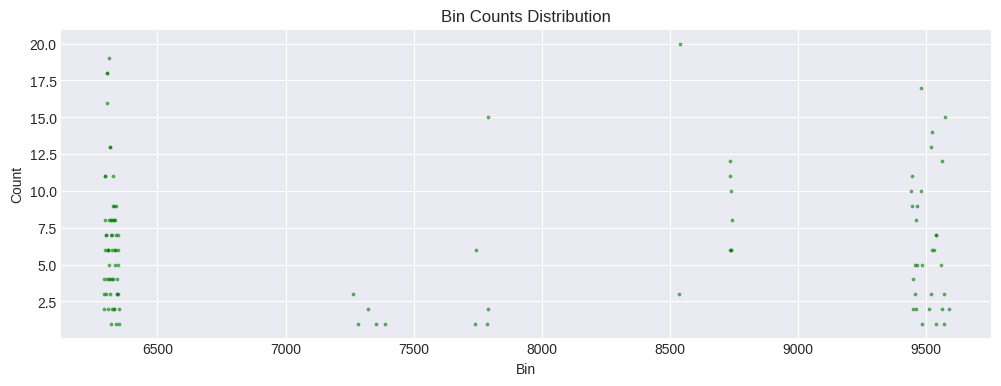

In [851]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')  # Example style, replace with your preferred style
fig, ax = plt.subplots(figsize=(12, 4))

# Assuming bin_counts index is what you want on the x-axis and the values are what you want on the y-axis
ax.scatter(bin_counts.index, bin_counts.values, s=3, alpha=0.5, color='green')  # s controls the marker size, alpha controls transparency

ax.set_xlabel('Bin')  # Assuming 'Bin' is the appropriate label
ax.set_ylabel('Count')
ax.set_title('Bin Counts Distribution')

plt.show()